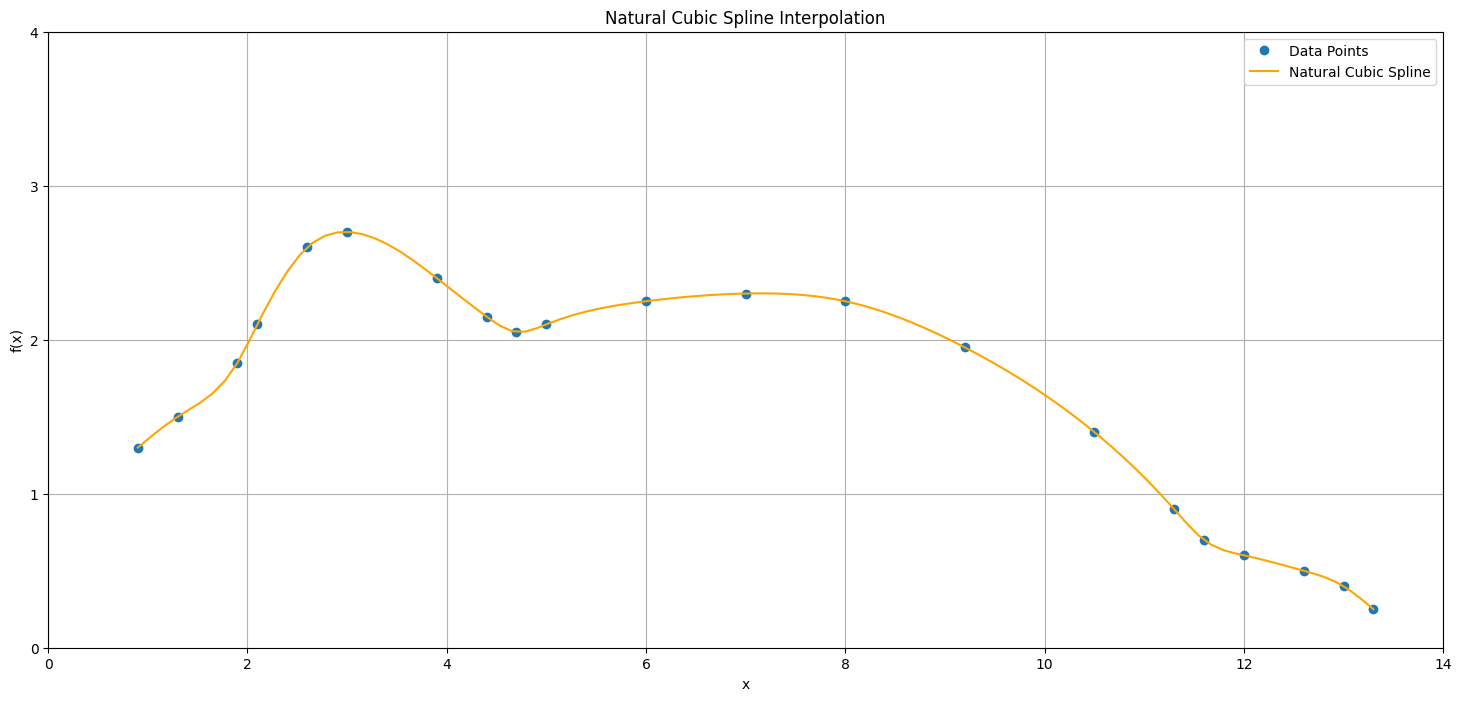

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

x = np.array([0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 
              5.0, 6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3])
f_x = np.array([1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1, 
                2.25, 2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4,0.25])

cs = CubicSpline(x, f_x, bc_type='natural')

x_new = np.linspace(x[0], x[-1], 100)
f_new = cs(x_new)



plt.figure(figsize=(18, 8))
plt.plot(x, f_x, 'o', label='Data Points')
plt.plot(x_new, f_new, label='Natural Cubic Spline', color='orange')
plt.xlim(0, 14)
plt.ylim(0, 4)
plt.title('Natural Cubic Spline Interpolation')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid()
plt.legend()
plt.yticks(np.arange(0, 5, 1))
plt.show()

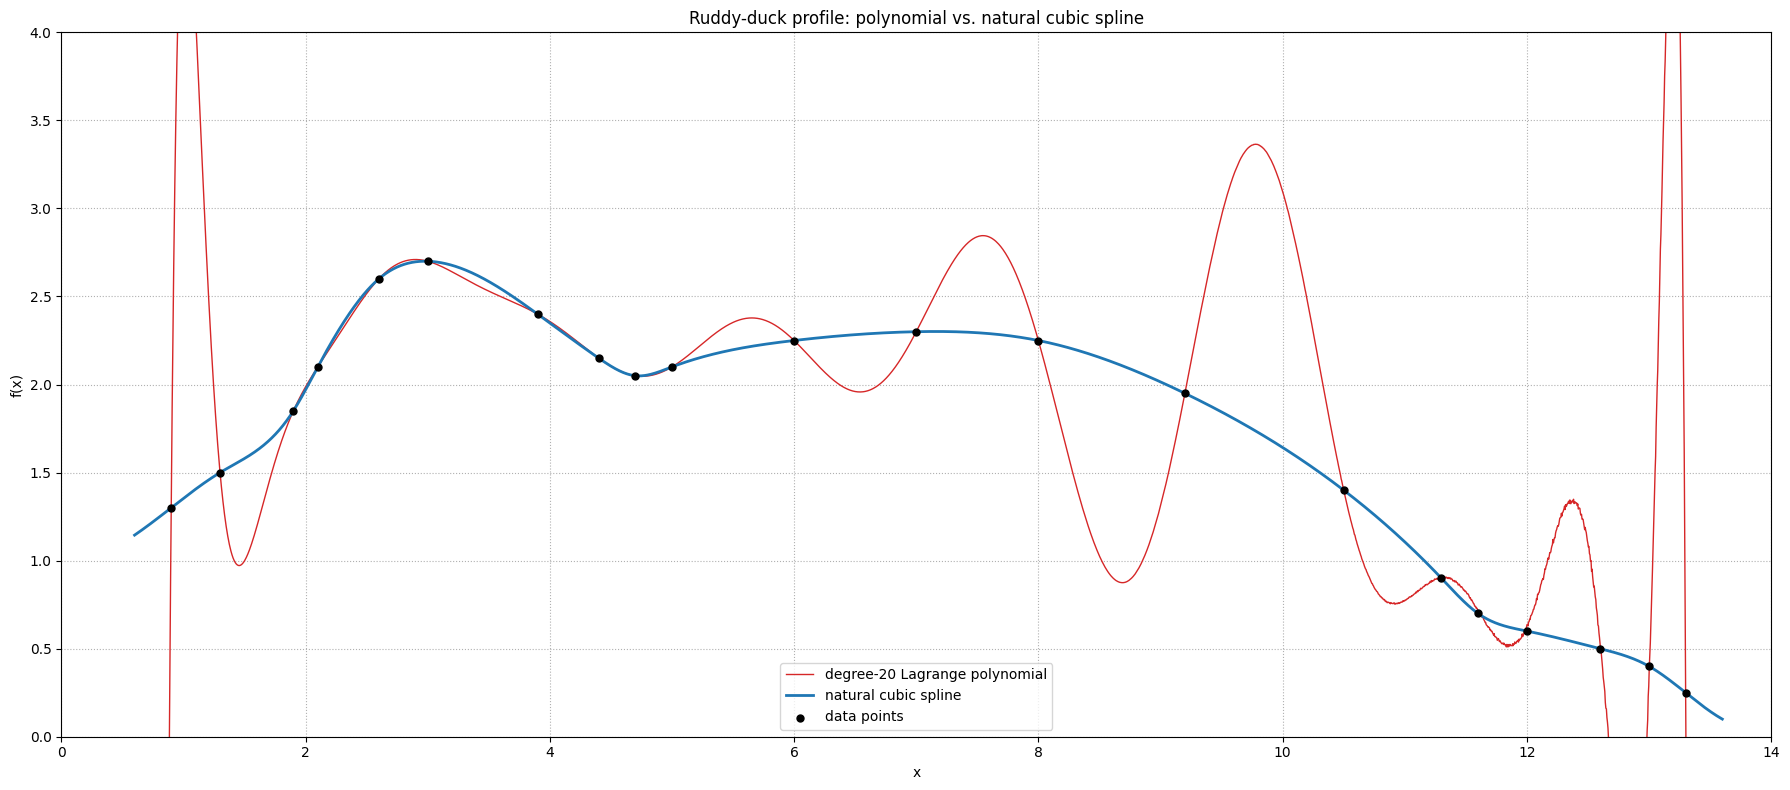

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


x_nodes = np.array([
    0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0,
    6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3
])

y_nodes = np.array([
    1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1,
    2.25, 2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25
])

b_tbl = np.array([ 5.40,  0.42,  1.09,  1.29,  0.59, -0.02, -0.50, -0.48,
                  -0.07,  0.26,  0.08,  0.01, -0.14, -0.34, -0.53, -0.73,
                  -0.49, -0.14, -0.18, -0.39])
c_tbl = np.array([ 0.00, -0.30,  1.41, -0.37, -1.04, -0.50, -0.03,  0.08,
                   1.27, -0.16, -0.03, -0.04, -0.11, -0.05, -0.10, -0.15,
                   0.94, -0.06,  0.00, -0.54])
d_tbl = np.array([-0.25,  0.95, -2.96, -0.45,  0.45,  0.17,  0.08,  1.31,
                  -1.58,  0.04,  0.00, -0.02,  0.02, -0.01,  0.00,  1.21,
                  -0.84,  0.04, -0.45,  0.60])


def natural_cubic_spline(x, a):
    x = np.asarray(x, float)
    a = np.asarray(a, float)
    n = len(x) - 1
    h = np.diff(x)

    alpha = np.zeros(n + 1)
    for i in range(1, n):
        alpha[i] = 3/h[i] * (a[i+1]-a[i]) - 3/h[i-1]*(a[i]-a[i-1])

    l = np.ones(n + 1)
    mu = np.zeros(n + 1)
    z = np.zeros(n + 1)

    for i in range(1, n):
        l[i]  = 2*(x[i+1]-x[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i] / l[i]
        z[i]  = (alpha[i] - h[i-1]*z[i-1]) / l[i]

    c = np.zeros(n + 1)
    b = np.zeros(n)
    d = np.zeros(n)

    for j in range(n-1, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (a[j+1]-a[j])/h[j] - h[j]*(c[j+1] + 2*c[j]) / 3
        d[j] = (c[j+1]-c[j]) / (3*h[j])

    return a[:-1], b, c[:-1], d

a_nat, b_nat, c_nat, d_nat = natural_cubic_spline(x_nodes, y_nodes)


intervals = [f"[{x_nodes[i]:.2f}, {x_nodes[i+1]:.2f}]" for i in range(20)]
df_compare = pd.DataFrame({
    "interval": intervals,
    "b (text)": b_tbl,
    "b (calc)": b_nat,
    "Δb": b_nat - b_tbl,
    "c (text)": c_tbl,
    "c (calc)": c_nat,
    "Δc": c_nat - c_tbl,
    "d (text)": d_tbl,
    "d (calc)": d_nat,
    "Δd": d_nat - d_tbl,
}).set_index("interval").round(4)


def poly_coeffs(x, y):
    V = np.vander(x, increasing=False)
    return np.linalg.solve(V, y)

poly_coef = poly_coeffs(x_nodes, y_nodes)

x_dense = np.linspace(x_nodes[0]-0.3, x_nodes[-1]+0.3, 3000)

def eval_spline(x_nodes, coeffs, x_eval):
    a, b, c, d = coeffs
    idx = np.searchsorted(x_nodes[:-1], x_eval, side='right') - 1
    idx = np.clip(idx, 0, len(a)-1)
    dx = x_eval - x_nodes[idx]
    return a[idx] + b[idx]*dx + c[idx]*dx**2 + d[idx]*dx**3

y_nat = eval_spline(x_nodes, (a_nat, b_nat, c_nat, d_nat), x_dense)
y_poly = np.polyval(poly_coef, x_dense)


plt.figure(figsize=(18, 8))
plt.plot(x_dense, y_poly, label="degree-20 Lagrange polynomial", lw=1, color="C3")
plt.plot(x_dense, y_nat,  label="natural cubic spline", lw=2,  color="C0")
plt.scatter(x_nodes, y_nodes, color="k", s=25, zorder=5, label="data points")
plt.ylim(-3, max(y_poly.max(), y_nat.max())+1)
plt.title("Ruddy-duck profile: polynomia" \
"l vs. natural cubic spline")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.grid(ls=":")
plt.xlim(0, 14)
plt.ylim(0, 4)
plt.legend()
plt.tight_layout()
plt.show()


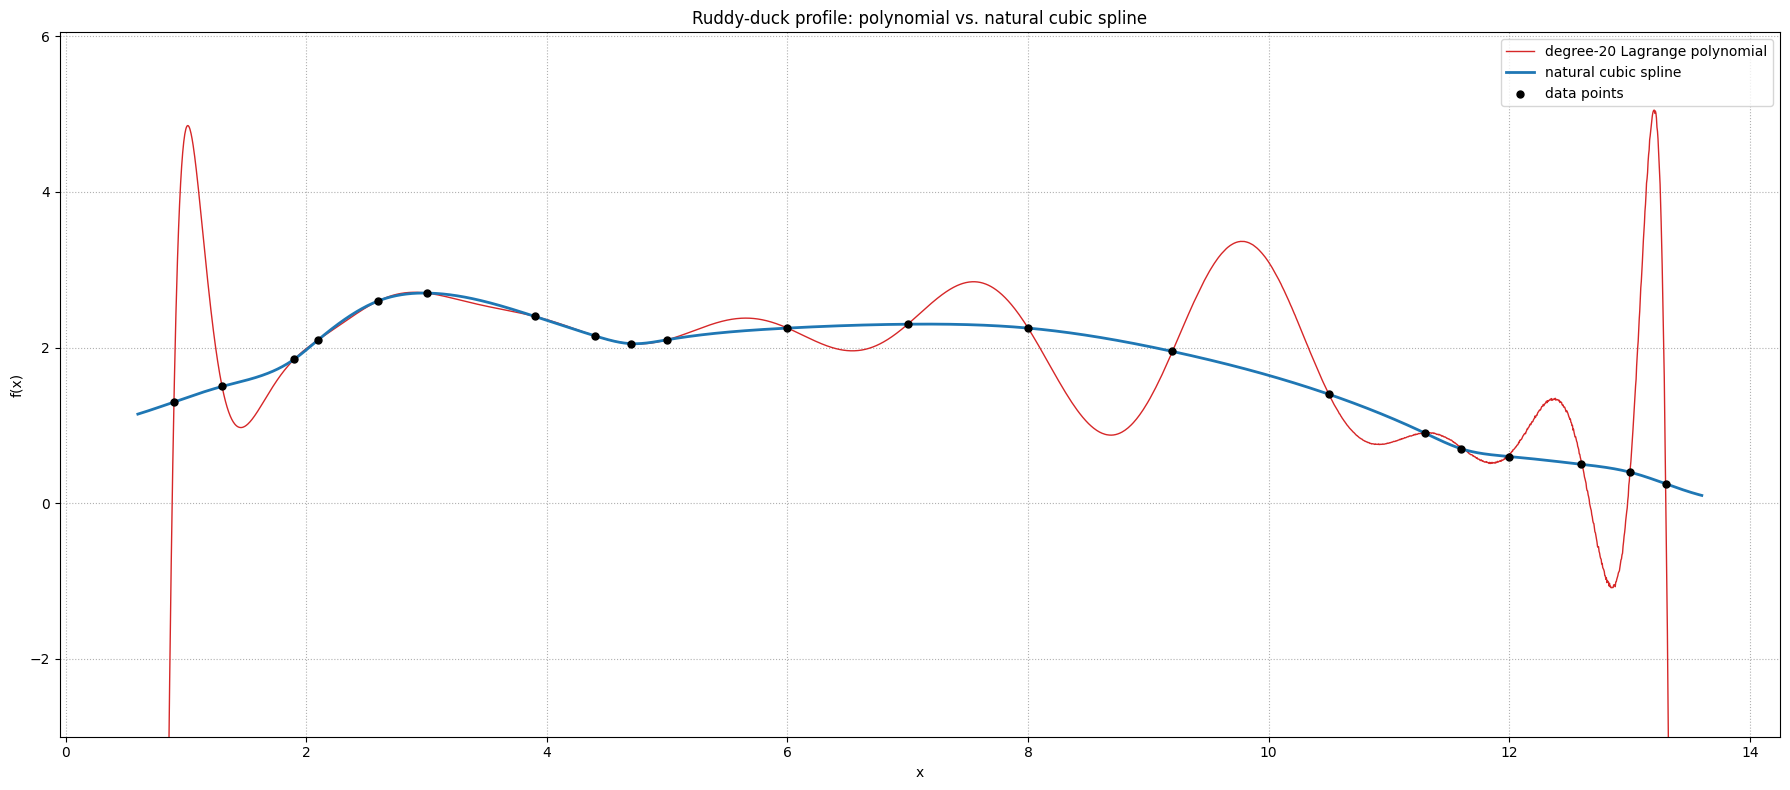

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


x_nodes = np.array([
    0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0,
    6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3
])

y_nodes = np.array([
    1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1,
    2.25, 2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25
])

b_tbl = np.array([ 5.40,  0.42,  1.09,  1.29,  0.59, -0.02, -0.50, -0.48,
                  -0.07,  0.26,  0.08,  0.01, -0.14, -0.34, -0.53, -0.73,
                  -0.49, -0.14, -0.18, -0.39])
c_tbl = np.array([ 0.00, -0.30,  1.41, -0.37, -1.04, -0.50, -0.03,  0.08,
                   1.27, -0.16, -0.03, -0.04, -0.11, -0.05, -0.10, -0.15,
                   0.94, -0.06,  0.00, -0.54])
d_tbl = np.array([-0.25,  0.95, -2.96, -0.45,  0.45,  0.17,  0.08,  1.31,
                  -1.58,  0.04,  0.00, -0.02,  0.02, -0.01,  0.00,  1.21,
                  -0.84,  0.04, -0.45,  0.60])


def natural_cubic_spline(x, a):
    x = np.asarray(x, float)
    a = np.asarray(a, float)
    n = len(x) - 1
    h = np.diff(x)

    alpha = np.zeros(n + 1)
    for i in range(1, n):
        alpha[i] = 3/h[i] * (a[i+1]-a[i]) - 3/h[i-1]*(a[i]-a[i-1])

    l = np.ones(n + 1)
    mu = np.zeros(n + 1)
    z = np.zeros(n + 1)

    for i in range(1, n):
        l[i]  = 2*(x[i+1]-x[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i] / l[i]
        z[i]  = (alpha[i] - h[i-1]*z[i-1]) / l[i]

    c = np.zeros(n + 1)
    b = np.zeros(n)
    d = np.zeros(n)

    for j in range(n-1, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (a[j+1]-a[j])/h[j] - h[j]*(c[j+1] + 2*c[j]) / 3
        d[j] = (c[j+1]-c[j]) / (3*h[j])

    return a[:-1], b, c[:-1], d

a_nat, b_nat, c_nat, d_nat = natural_cubic_spline(x_nodes, y_nodes)


intervals = [f"[{x_nodes[i]:.2f}, {x_nodes[i+1]:.2f}]" for i in range(20)]
df_compare = pd.DataFrame({
    "interval": intervals,
    "b (text)": b_tbl,
    "b (calc)": b_nat,
    "Δb": b_nat - b_tbl,
    "c (text)": c_tbl,
    "c (calc)": c_nat,
    "Δc": c_nat - c_tbl,
    "d (text)": d_tbl,
    "d (calc)": d_nat,
    "Δd": d_nat - d_tbl,
}).set_index("interval").round(4)


def poly_coeffs(x, y):
    V = np.vander(x, increasing=False)
    return np.linalg.solve(V, y)

poly_coef = poly_coeffs(x_nodes, y_nodes)


x_dense = np.linspace(x_nodes[0]-0.3, x_nodes[-1]+0.3, 3000)

def eval_spline(x_nodes, coeffs, x_eval):
    a, b, c, d = coeffs
    idx = np.searchsorted(x_nodes[:-1], x_eval, side='right') - 1
    idx = np.clip(idx, 0, len(a)-1)
    dx = x_eval - x_nodes[idx]
    return a[idx] + b[idx]*dx + c[idx]*dx**2 + d[idx]*dx**3

y_nat = eval_spline(x_nodes, (a_nat, b_nat, c_nat, d_nat), x_dense)
y_poly = np.polyval(poly_coef, x_dense)


plt.figure(figsize=(18, 8))
plt.plot(x_dense, y_poly, label="degree-20 Lagrange polynomial", lw=1, color="C3")
plt.plot(x_dense, y_nat,  label="natural cubic spline", lw=2,  color="C0")
plt.scatter(x_nodes, y_nodes, color="k", s=25, zorder=5, label="data points")
plt.ylim(-3, max(y_poly.max(), y_nat.max())+1)
plt.title("Ruddy-duck profile: polynomial vs. natural cubic spline")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.grid(ls=":")
plt.legend()

plt.tight_layout()
plt.show()
